In [7]:
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device = {device}')

Device = cuda


To verify the ability of **PINN**(Physics Informed Neural Networks) for solving wave equations, we test it on the following 1d homogenenous wave equation:
\begin{equation}
\begin{split}
&u_{tt} - c^2u_{xx} = 0, -1 < x < 1, t > 0 \\
&u(-1, t) = u(1, t) = 0\\
&u(x, 0) = \cos\frac{\pi x}{2}, u_t(x, 0) = 0
\end{split}
\end{equation}
The theoretical solution of it is:
$$ u(x, t) = \cos\frac{\pi ct}{2}\cos\frac{\pi x}{2}$$

In [8]:
class DNN(nn.Module):
    """Fully connected neural network
    """
    def __init__(self, layer_sizes):
        super(DNN, self).__init__()
        self.layer_sizes = layer_sizes
        self.linears = nn.ModuleList()
        for i in range(1, len(layer_sizes)):
            self.linears.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))

    def forward(self, x):
        for linear in self.linears[:-1]:
            # x = torch.nn.functional.softplus(linear(x))
            # x = torch.sigmoid(linear(x))
            # x = torch.nn.functional.relu(linear(x))
            # x = torch.tanh(linear(x))
            x = torch.sin(linear(x))
        x = self.linears[-1](x)
        return x 

In [9]:
class PINN(nn.Module):
    """Physic informed neural network
    """
    def __init__(self, c, A, layer_sizes, Ni, Nb, Nc):
        super(PINN, self).__init__()
        self.c = c
        self.A = A # amplitude
        
        # Initial condition
        xi = np.random.uniform(-1, 1, (Ni, 1))
        self.xi = torch.tensor(xi, dtype=torch.float32, requires_grad=True, device=device)
        self.ti = torch.zeros(Ni, 1, dtype=torch.float32, requires_grad=True, device=device)
        ui = np.cos(np.pi * xi / 2) * A # !!!
        self.ui = torch.tensor(ui, dtype=torch.float32, requires_grad=True, device=device)
        
        # Boundary condition
        tl = np.random.uniform(0, 1, (Nb, 1))
        xl = np.ones((Nb, 1)) * (-1)
        self.tl = torch.tensor(tl, dtype=torch.float32, requires_grad=True, device=device)
        self.xl = torch.tensor(xl, dtype=torch.float32, requires_grad=True, device=device)
        tr = np.random.uniform(0, 1, (Nb, 1))
        xr = np.ones((Nb, 1))  
        self.tr = torch.tensor(tr, dtype=torch.float32, requires_grad=True, device=device)
        self.xr = torch.tensor(xr, dtype=torch.float32, requires_grad=True, device=device)        
        
        # Collocation points
        xf = np.random.uniform(-1, 1, (Nc, 1))
        tf = np.random.uniform(0, 1, (Nc, 1))
        self.xf = torch.tensor(xf, dtype=torch.float32, requires_grad=True, device=device)
        self.tf = torch.tensor(tf, dtype=torch.float32, requires_grad=True, device=device)
        
        # Deal with l2 error
        self.error = []
        t_star = np.linspace(0, 1, 200)[:, None]
        x_star = np.linspace(0, 1, 200)[:, None]
        X_star, T_star = np.meshgrid(x_star, t_star)
        self.t_star = T_star.flatten()[:,None]
        self.x_star = X_star.flatten()[:,None]
        self.u_star = np.cos(np.pi * c * self.t_star / 2) * np.cos(np.pi * self.x_star / 2) * A #!!!
            
        self.loss = []
        self.dnn = DNN(layer_sizes).to(device)
        self.iter = 0
        self.max_num_iter = 10000
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
#         self.optimizer = torch.optim.Adam(
#             self.dnn.parameters(), 
#             lr=0.01, 
#         )
        
    def net_u(self, x, t):
        u = self.dnn(torch.cat((x, t), dim=1))
        return u 

    def net_f(self, x, t):
        u = self.net_u(x, t)

        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_tt = torch.autograd.grad(
            u_t, t, 
            grad_outputs=torch.ones_like(u_t),
            retain_graph=True,
            create_graph=True
        )[0]

        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]

        Lu = u_tt  - self.c ** 2 * u_xx
        return Lu 
    
#     def initial_loss(self):
#         u = self.net_u(self.xi, self.ti)
#         li = torch.mean(torch.square(u - self.ui))
#         self.loss_i.append(li.item())
#         return li
    
#     def boundary_loss(self):
#         ul = self.net_u(self.xl, self.tl)
#         ur = self.net_u(self.xr, self.tr)
#         lb = torch.mean(torch.square(ul)) +\
#              torch.mean(torch.square(ur))
#         self.loss_b.append(lb.item())
#         return lb
                        
#     def collocation_loss(self):
#         Lu = self.net_f(self.xf, self.tf)
#         lc = torch.mean(torch.square(Lu))
#         self.loss_c.append(lc.item())
#         return lc

    def compute_error(self):
        self.dnn.eval()
        u_pred, _ = self.predict(self.x_star, self.t_star)
        error = np.linalg.norm(self.u_star-u_pred,2)/np.linalg.norm(self.u_star,2)
        error = error ** 2
        self.error.append(error)
        self.dnn.train()

    def loss_func(self):
        self.compute_error()
        self.optimizer.zero_grad()
        
        ui = self.net_u(self.xi, self.ti)
        ui_t = torch.autograd.grad(
            ui, self.ti,
            grad_outputs=torch.ones_like(ui),
            retain_graph=True,
            create_graph=True
        )[0]
        loss_i = torch.mean((self.ui - ui) ** 2) + torch.mean(ui_t ** 2)
        
        f_pred = self.net_f(self.xf, self.tf)
        loss_f = torch.mean(f_pred ** 2)
        
        ul = self.net_u(self.xl, self.tl)
        ur = self.net_u(self.xr, self.tr)
        loss_b = torch.mean(ul ** 2) + torch.mean(ur ** 2)

        loss = loss_i + loss_b +  loss_f
        self.loss.append(loss.item())
        
        loss.backward()
        
        if self.iter % 100 == 0:
            print("Iter %d, Loss: %.4e, Initial loss: %.4e, Boundary loss: %.4e, Collocation loss : %.4e" 
                  % (self.iter, loss.item(), loss_i.item(), loss_b.item(), loss_f.item()))
        self.iter += 1
        return loss
    
    # def compute_loss(self):
    #     self.optimizer.zero_grad()
    #     li = self.initial_loss()
    #     lb = self.boundary_loss()
    #     lc = self.collocation_loss()
    #     l = li + lb + lc 
    #     l.backward()
    #     self.loss.append(l.item())
    #     self.num_iter += 1
    #     if self.num_iter % 500 == 0 or self.num_iter == self.max_num_iter:
    #         self.loss.append(l.item())
    #         print("Iter %d, Loss: %.4e, Initial loss: %.4e, Boundary loss: %.4e, Collocation loss : %.4e" 
    #               % (self.num_iter, l.item(), li.item(), lb.item(), lc.item()))
    #     return l

    def train(self):
        self.dnn.train()
        while self.iter < self.max_num_iter:
            self.optimizer.step(self.loss_func)

            
    def predict(self, x, t):
        self.dnn.eval() 
        x = torch.tensor(x, requires_grad=True, dtype=torch.float32, device=device)
        t = torch.tensor(t, requires_grad=True, dtype=torch.float32, device=device)
        u = self.net_u(x, t)
        Lu = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        Lu = Lu.detach().cpu().numpy()
        return u, Lu

In [13]:
c = 1
A = 1e-5
Ni = 200
Nb = 200
Nc = 10000
layer_sizes = [2] + [20] * 5 + [1]
model = PINN(c, A, layer_sizes, Ni, Nb, Nc)

In [14]:
model.train()

Iter 0, Loss: 5.9807e-03, Initial loss: 1.8519e-03, Boundary loss: 4.1026e-03, Collocation loss : 2.6260e-05
Iter 100, Loss: 3.3680e-07, Initial loss: 1.2174e-07, Boundary loss: 1.1093e-08, Collocation loss : 2.0396e-07
Iter 200, Loss: 3.3680e-07, Initial loss: 1.2174e-07, Boundary loss: 1.1093e-08, Collocation loss : 2.0396e-07
Iter 300, Loss: 3.3680e-07, Initial loss: 1.2174e-07, Boundary loss: 1.1093e-08, Collocation loss : 2.0396e-07
Iter 400, Loss: 3.3680e-07, Initial loss: 1.2174e-07, Boundary loss: 1.1093e-08, Collocation loss : 2.0396e-07


KeyboardInterrupt: 

975.8251408456097

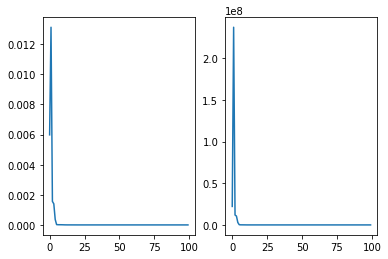

In [17]:
loss, error = model.loss, model.error
fig, ax = plt.subplots(1, 2)
ax[0].plot(loss[:100])
ax[1].plot(error[:100])
loss = np.array(loss)
error = np.array(error)
# loss_error = np.r_[loss[np.newaxis, :], error[np.newaxis, :]]
# np.save('./data/loss_error_sin.npy', loss_error)
error.min()

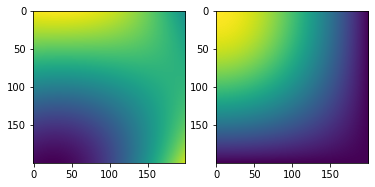

In [20]:
u_pred, _ = model.predict(model.x_star, model.t_star)
u_pred = u_pred.reshape(200, 200)
plt.subplot(121)
plt.imshow(u_pred)
plt.subplot(122)
plt.imshow(model.u_star.reshape(200, 200))

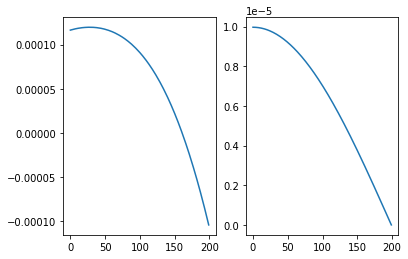

In [24]:
plt.subplot(121)
plt.plot(u_pred[10, :])
plt.subplot(122)
plt.plot(model.u_star.reshape(200, 200)[10, :])

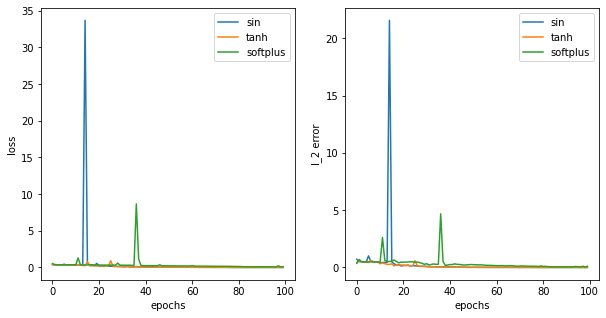

In [29]:
loss_error_sin = np.load('data/loss_error_sin.npy')
loss_error_tanh = np.load('data/loss_error_tanh.npy')
loss_error_softplus = np.load('data/loss_error_softplus.npy')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].plot(loss_error_sin[0][:100], label='sin')
ax[0].plot(loss_error_tanh[0][:100], label='tanh')
ax[0].plot(loss_error_softplus[0][:100], label='softplus')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(loss_error_sin[1][:100], label='sin')
ax[1].plot(loss_error_tanh[1][:100], label='tanh')
ax[1].plot(loss_error_softplus[1][:100], label='softplus')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel(r'l_2 error')
ax[1].legend()
plt.show()

We find that different activation function have a strong impact on the training process of PINN. `Sin`, `Tanh` and `Softplus` perform mush better than traditional `ReLU` and `Sigmoid`.
By compare different optimizer, we find that `Adam` oscillates much heavily than `LBFGS` but take less time to convergence. 